In [9]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from datetime import datetime, timedelta
from data_loading_finance.loading_data import LoadingData
from ts_tools.tools import tools

from scipy.stats import zscore
from pmdarima.arima import ARIMA
from pmdarima.metrics import smape
from pmdarima.model_selection import cross_val_score, SlidingWindowForecastCV
import warnings

In [10]:
warnings.filterwarnings("ignore")

In [11]:
def load_and_preprocess_data(tickers):
    tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
    loader = LoadingData(tickers=tickers)
    ts = loader.get_data(start_date='2015-01-01', interval='1mo')
    ts_tools = tools()
    ts = ts_tools.ts_prepartion(ts, 'Date', 'Adj Close')
    ts['y'] = np.log(ts['y'].div(ts.groupby('unique_id')['y'].shift(1)))
    ts = ts.replace([np.inf, -np.inf], np.nan).dropna()
    return ts

In [12]:
def detect_and_correct_anomalies(group):
    group = group.sort_values(by='ds', ascending=True).reset_index(drop=True)
    group['Z-Score'] = abs(zscore(group['y']))
    group.loc[group['Z-Score'] > 2, 'y'] = np.nan
    group['y'] = group['y'].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
    return group.drop(columns=['Z-Score'])

In [13]:
def plot_anomalies(ts, tickers):
    ts_original = ts.groupby('unique_id')
    ts_corrected = ts.groupby('unique_id').apply(detect_and_correct_anomalies).reset_index(drop=True).groupby('unique_id')

    for ticker in tickers:
        plt.figure(figsize=(14, 7))
        original_data = ts_original.get_group(ticker)
        corrected_data = ts_corrected.get_group(ticker)
        plt.plot(original_data['ds'], original_data['y'], label='With Anomaly')
        plt.plot(corrected_data['ds'], corrected_data['y'], label='Without Anomaly', linestyle='--')
        plt.title(f'{ticker}')
        plt.xlabel('Fecha')
        plt.ylabel('Valor Ajustado de Cierre')
        plt.legend()
        plt.show()

In [14]:
def optimize_ARIMA(trial, ts_ARIMA, horizon):
    ts_ARIMA = ts_ARIMA.dropna()
    p = trial.suggest_int('p', 0, 5)
    d = trial.suggest_int('d', 0, 5)
    q = trial.suggest_int('q', 0, 5)
    model = ARIMA(order=(p, d, q))
    cv = SlidingWindowForecastCV(window_size=len(ts_ARIMA) // 2, step=5, h=horizon)
    cv_scores = cross_val_score(model, ts_ARIMA['y'], scoring='smape', cv=cv, verbose=2)
    return np.mean(cv_scores)

In [15]:
def forecast_for_client(id, ts, horizon_months, proporcion_entrenamiento):
    try:
        ts = ts.drop('unique_id', axis=1).sort_values(by='ds').reset_index(drop=True)
        ts['ds'] = pd.to_datetime(ts['ds'])

        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: optimize_ARIMA(trial, ts, horizon_months), n_trials=50)

        best_params = study.best_trial.params
        model = ARIMA(order=(best_params['p'], best_params['d'], best_params['q']))
        model_fit = model.fit(ts['y'])

        future_dates = pd.date_range(start=ts['ds'].max(), periods=horizon_months, freq='MS')
        forecast = model_fit.predict(n_periods=horizon_months)
        forecast_df = pd.DataFrame({'ds': future_dates, 'yhat': forecast})
        forecast_df['ticker'] = id
        forecast_df['yhat'] = forecast_df['yhat'].round(2)
        forecast_df['ds'] = forecast_df['ds'].dt.strftime('%d-%m-%Y')

        resultado_accuracy = {
            'ticker': id,
            'accuracy': study.best_value,
            'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
        }

        return resultado_accuracy, forecast_df[['ticker', 'ds', 'yhat']].to_dict('records')

    except Exception as e:
        print(f'Error procesando {id}. No existe suficiente información para realizar el forecasting: {e}')
        return None, None

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


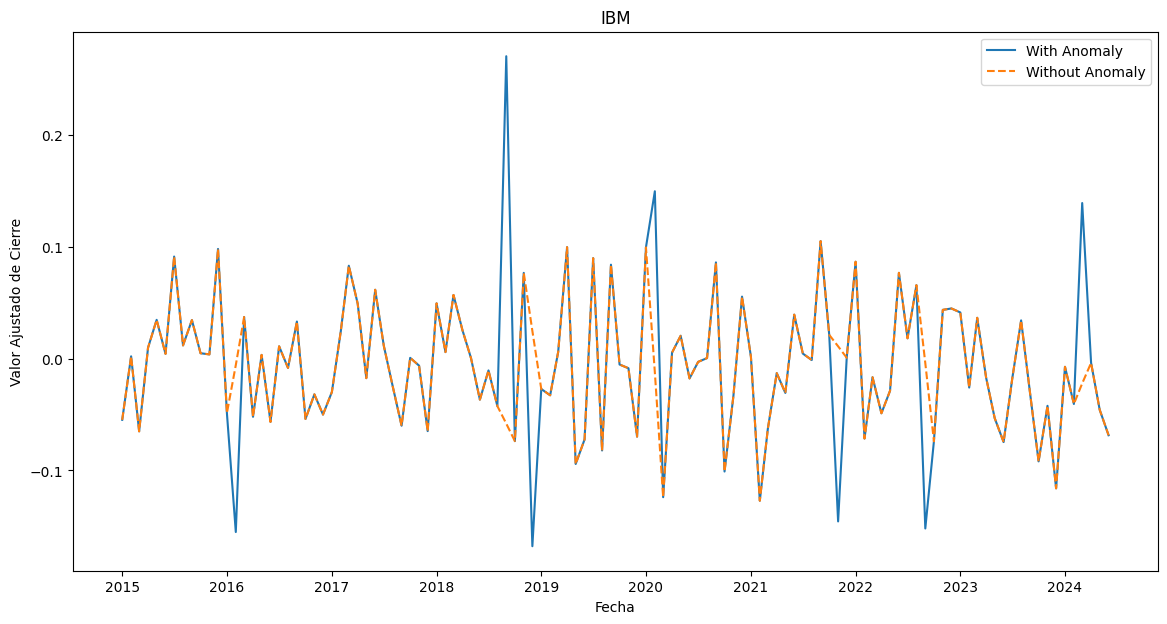

[I 2024-07-19 11:12:06,661] A new study created in memory with name: no-name-2740ab1f-51cb-4d5e-b38c-ff8e40ee6d09


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:12:08,760] Trial 0 finished with value: 159.21070359741398 and parameters: {'p': 3, 'd': 0, 'q': 1}. Best is trial 0 with value: 159.21070359741398.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:12:12,616] Trial 1 finished with value: 162.63005943176964 and parameters: {'p': 4, 'd': 0, 'q': 1}. Best is trial 0 with value: 159.21070359741398.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:12:18,068] Trial 2 finished with value: 158.81222699541684 and parameters: {'p': 3, 'd': 4, 'q': 2}. Best is trial 2 with value: 158.81222699541684.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:12:22,503] Trial 3 finished with value: 145.02170290831444 and parameters: {'p': 3, 'd': 2, 'q': 4}. Best is trial 3 with value: 145.02170290831444.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:12:31,670] Trial 4 finished with value: 154.92852294449824 and parameters: {'p': 5, 'd': 4, 'q': 4}. Best is trial 3 with value: 145.02170290831444.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................


[I 2024-07-19 11:12:32,617] Trial 5 finished with value: 156.10170174853323 and parameters: {'p': 2, 'd': 2, 'q': 0}. Best is trial 3 with value: 145.02170290831444.


[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:12:40,185] Trial 6 finished with value: 156.85006929922636 and parameters: {'p': 4, 'd': 3, 'q': 5}. Best is trial 3 with value: 145.02170290831444.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:12:45,037] Trial 7 finished with value: 160.19323024959903 and parameters: {'p': 2, 'd': 1, 'q': 5}. Best is trial 3 with value: 145.02170290831444.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................


[I 2024-07-19 11:12:45,349] Trial 8 finished with value: 196.1760738146978 and parameters: {'p': 0, 'd': 5, 'q': 0}. Best is trial 3 with value: 145.02170290831444.


[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:12:49,387] Trial 9 finished with value: 154.01913603217707 and parameters: {'p': 4, 'd': 0, 'q': 3}. Best is trial 3 with value: 145.02170290831444.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:12:52,042] Trial 10 finished with value: 157.60131742123482 and parameters: {'p': 0, 'd': 2, 'q': 3}. Best is trial 3 with value: 145.02170290831444.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:12:59,353] Trial 11 finished with value: 156.97926164448205 and parameters: {'p': 5, 'd': 1, 'q': 3}. Best is trial 3 with value: 145.02170290831444.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:13:04,420] Trial 12 finished with value: 161.81761834160793 and parameters: {'p': 4, 'd': 1, 'q': 4}. Best is trial 3 with value: 145.02170290831444.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:13:08,186] Trial 13 finished with value: 149.0346254408161 and parameters: {'p': 1, 'd': 3, 'q': 4}. Best is trial 3 with value: 145.02170290831444.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:13:11,771] Trial 14 finished with value: 149.0346254408161 and parameters: {'p': 1, 'd': 3, 'q': 4}. Best is trial 3 with value: 145.02170290831444.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:13:16,326] Trial 15 finished with value: 167.511638020277 and parameters: {'p': 1, 'd': 3, 'q': 5}. Best is trial 3 with value: 145.02170290831444.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:13:20,204] Trial 16 finished with value: 157.86012990908202 and parameters: {'p': 1, 'd': 4, 'q': 4}. Best is trial 3 with value: 145.02170290831444.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:13:23,248] Trial 17 finished with value: 149.71753012328634 and parameters: {'p': 2, 'd': 2, 'q': 2}. Best is trial 3 with value: 145.02170290831444.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:13:28,605] Trial 18 finished with value: 168.51683591687583 and parameters: {'p': 3, 'd': 5, 'q': 4}. Best is trial 3 with value: 145.02170290831444.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:13:33,240] Trial 19 finished with value: 167.511638020277 and parameters: {'p': 1, 'd': 3, 'q': 5}. Best is trial 3 with value: 145.02170290831444.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:13:35,947] Trial 20 finished with value: 157.60131742123482 and parameters: {'p': 0, 'd': 2, 'q': 3}. Best is trial 3 with value: 145.02170290831444.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:13:39,417] Trial 21 finished with value: 149.0346254408161 and parameters: {'p': 1, 'd': 3, 'q': 4}. Best is trial 3 with value: 145.02170290831444.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:13:43,999] Trial 22 finished with value: 161.98559291493032 and parameters: {'p': 2, 'd': 4, 'q': 4}. Best is trial 3 with value: 145.02170290831444.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:13:47,228] Trial 23 finished with value: 149.61342068956895 and parameters: {'p': 1, 'd': 3, 'q': 3}. Best is trial 3 with value: 145.02170290831444.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:13:52,213] Trial 24 finished with value: 145.498743370611 and parameters: {'p': 3, 'd': 2, 'q': 5}. Best is trial 3 with value: 145.02170290831444.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:13:56,860] Trial 25 finished with value: 154.57908345760708 and parameters: {'p': 3, 'd': 1, 'q': 5}. Best is trial 3 with value: 145.02170290831444.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:14:02,022] Trial 26 finished with value: 145.498743370611 and parameters: {'p': 3, 'd': 2, 'q': 5}. Best is trial 3 with value: 145.02170290831444.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:14:07,017] Trial 27 finished with value: 145.498743370611 and parameters: {'p': 3, 'd': 2, 'q': 5}. Best is trial 3 with value: 145.02170290831444.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:14:12,063] Trial 28 finished with value: 150.94332142396533 and parameters: {'p': 4, 'd': 1, 'q': 5}. Best is trial 3 with value: 145.02170290831444.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:14:17,127] Trial 29 finished with value: 145.498743370611 and parameters: {'p': 3, 'd': 2, 'q': 5}. Best is trial 3 with value: 145.02170290831444.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:14:21,500] Trial 30 finished with value: 160.19323024959903 and parameters: {'p': 2, 'd': 1, 'q': 5}. Best is trial 3 with value: 145.02170290831444.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:14:26,438] Trial 31 finished with value: 145.498743370611 and parameters: {'p': 3, 'd': 2, 'q': 5}. Best is trial 3 with value: 145.02170290831444.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:14:31,455] Trial 32 finished with value: 145.498743370611 and parameters: {'p': 3, 'd': 2, 'q': 5}. Best is trial 3 with value: 145.02170290831444.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:14:36,067] Trial 33 finished with value: 140.6919645974319 and parameters: {'p': 4, 'd': 0, 'q': 5}. Best is trial 33 with value: 140.6919645974319.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:14:39,511] Trial 34 finished with value: 153.480726430428 and parameters: {'p': 5, 'd': 0, 'q': 1}. Best is trial 33 with value: 140.6919645974319.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:14:43,631] Trial 35 finished with value: 158.45130737534424 and parameters: {'p': 4, 'd': 0, 'q': 4}. Best is trial 33 with value: 140.6919645974319.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:14:46,978] Trial 36 finished with value: 156.2278892552459 and parameters: {'p': 4, 'd': 0, 'q': 2}. Best is trial 33 with value: 140.6919645974319.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:14:51,585] Trial 37 finished with value: 154.57908345760708 and parameters: {'p': 3, 'd': 1, 'q': 5}. Best is trial 33 with value: 140.6919645974319.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:14:59,557] Trial 38 finished with value: 161.96408288372734 and parameters: {'p': 4, 'd': 4, 'q': 4}. Best is trial 33 with value: 140.6919645974319.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:15:06,350] Trial 39 finished with value: 148.081757628368 and parameters: {'p': 5, 'd': 1, 'q': 5}. Best is trial 33 with value: 140.6919645974319.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:15:10,487] Trial 40 finished with value: 140.71250443354964 and parameters: {'p': 2, 'd': 2, 'q': 4}. Best is trial 33 with value: 140.6919645974319.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:15:14,763] Trial 41 finished with value: 140.71250443354964 and parameters: {'p': 2, 'd': 2, 'q': 4}. Best is trial 33 with value: 140.6919645974319.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:15:17,917] Trial 42 finished with value: 153.60459778839933 and parameters: {'p': 2, 'd': 2, 'q': 3}. Best is trial 33 with value: 140.6919645974319.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:15:21,603] Trial 43 finished with value: 140.71250443354964 and parameters: {'p': 2, 'd': 2, 'q': 4}. Best is trial 33 with value: 140.6919645974319.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:15:25,366] Trial 44 finished with value: 148.7468113694181 and parameters: {'p': 2, 'd': 1, 'q': 4}. Best is trial 33 with value: 140.6919645974319.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:15:29,039] Trial 45 finished with value: 152.79036514695233 and parameters: {'p': 2, 'd': 3, 'q': 3}. Best is trial 33 with value: 140.6919645974319.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:15:32,909] Trial 46 finished with value: 140.71250443354964 and parameters: {'p': 2, 'd': 2, 'q': 4}. Best is trial 33 with value: 140.6919645974319.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:15:36,771] Trial 47 finished with value: 148.7468113694181 and parameters: {'p': 2, 'd': 1, 'q': 4}. Best is trial 33 with value: 140.6919645974319.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:15:40,216] Trial 48 finished with value: 153.60459778839933 and parameters: {'p': 2, 'd': 2, 'q': 3}. Best is trial 33 with value: 140.6919645974319.


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


[I 2024-07-19 11:15:43,301] Trial 49 finished with value: 152.20444337712098 and parameters: {'p': 2, 'd': 0, 'q': 4}. Best is trial 33 with value: 140.6919645974319.


[({'ticker': 'IBM', 'accuracy': 140.6919645974319, 'timestamp': '2024-07-19 11:15:43'}, [{'ticker': 'IBM', 'ds': '01-06-2024', 'yhat': -0.01}, {'ticker': 'IBM', 'ds': '01-07-2024', 'yhat': -0.01}, {'ticker': 'IBM', 'ds': '01-08-2024', 'yhat': -0.01}])]


In [16]:
if __name__ == "__main__":
    tickers = ['IBM']
    ts = load_and_preprocess_data(tickers)
    ts_not_anom = ts.groupby('unique_id').apply(detect_and_correct_anomalies).reset_index(drop=True)
    plot_anomalies(ts, tickers)
    forecast_results = [forecast_for_client(ticker, ts_not_anom[ts_not_anom['unique_id'] == ticker], 3, 0.80) for ticker in tickers]
    print(forecast_results)